# A rotating mesh with pulsations

In [1]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation, add_pulsation, evaluate_pulsations
from spice.plots import plot_3D_mesh_and_spectrum
from spice.spectrum import simulate_spectrum
import astropy.units as u
import jax
import jax.numpy as jnp
import numpy as np
from transformer_payne import Blackbody, TransformerPayne
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True)

PHOEBE: passband "Bolometric:900-40000" has a newer version available.  Run phoebe.list_passband_online_history("Bolometric:900-40000") to get a list of available changes and phoebe.update_passband("Bolometric:900-40000") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.


Let's use the simplest example for the sake of speed - the blackbody flux from the ```transformer_payne``` package.

In [2]:
bb = TransformerPayne.download()

The API is in the functional paradigm - you pass a "model" mesh, and the function returns a modified version of the mesh. However, the original passed mesh still remains if you choose not to overwrite these variables.

$A = D + \sum_{n=1}^N cos(\frac{n}{P}t_n-\phi_n)$

In [3]:
import pickle

with open('../src/spice/icosphere_cache/icosphere_5.pickle', 'rb') as f:
    m = pickle.load(f)
    print(len(m[3]))

20480


In [4]:
base_temp = 5700

m = IcosphereModel.construct(100, u.solRad.to(u.cm), u.solMass.to(u.kg),
                             bb.to_parameters(), bb.parameter_names)
print(len(m.centers))

m = add_pulsation(m, jnp.array([0, 0]), 10., jnp.array([[1e-6, 0.]]))

320


In [5]:
TIMESTAMPS = jnp.linspace(5., 20., 1000)

In [6]:
from spice.plots import plot_3D_sequence
mps = [evaluate_pulsations(m, t) for t in TIMESTAMPS]

In [7]:
start_radius = jnp.mean(m.radii)
mean_radii = [jnp.mean(mp.radii)/start_radius for mp in mps]

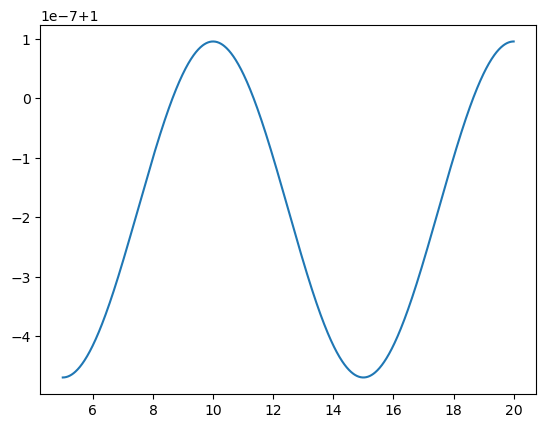

In [8]:
plt.plot(TIMESTAMPS, mean_radii)
plt.show()

In [9]:
start_area = jnp.sum(m.areas)
areas = [jnp.sum(mp.areas)/start_area for mp in mps]

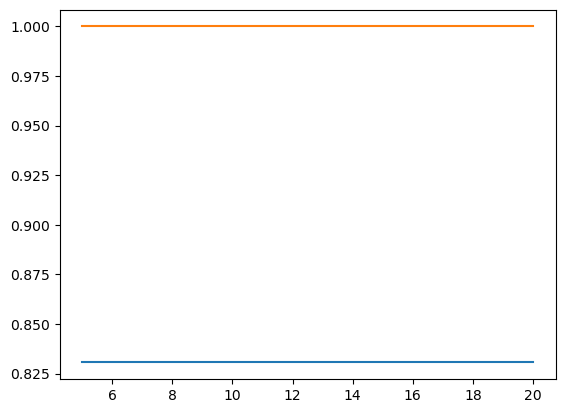

In [10]:
plt.plot(TIMESTAMPS, areas)
plt.plot(TIMESTAMPS, np.array(mean_radii)**2)

## Spectrum emulation

In [11]:
mps[0].mus.shape

(320,)

In [12]:
bb

In [22]:
simulate_spectrum(bb.intensity, mps[0], jnp.log10(vws), disable_doppler_shift=False)

Array([[2.76000478e+36, 2.89204740e+36],
       [2.47172095e+36, 2.56387632e+36],
       [2.40346363e+36, 2.58388581e+36],
       [3.93806808e+36, 4.18250637e+36],
       [3.24458110e+36, 3.24693829e+36],
       [2.36817601e+36, 2.36833499e+36],
       [1.72739282e+36, 1.72799129e+36],
       [1.28827288e+36, 1.28822009e+36],
       [9.64236268e+35, 9.65289948e+35],
       [1.03054088e+36, 1.03073613e+36]], dtype=float64)

In [13]:
vws = jnp.linspace(100., 12000., 10)
specs = [simulate_spectrum(bb.intensity, mp0, jnp.log10(vws), disable_doppler_shift=False) for mp0 in mps[:2]]

(array(1024), array(94))
(array(1024), array(94))


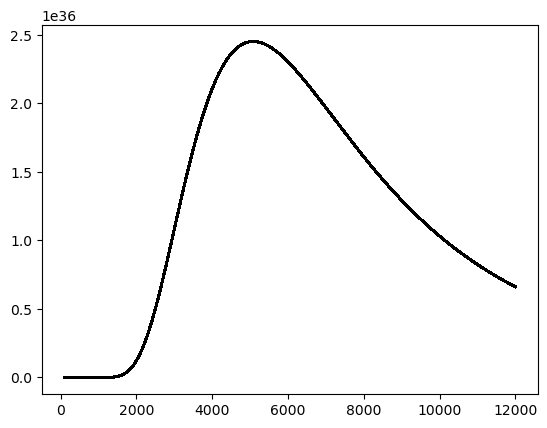

In [39]:
import matplotlib.pyplot as plt

for spec in specs:
    plt.plot(vws, spec, color='black', alpha=0.5)

(<Figure size 2400x1000 with 3 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>,
 <Axes: xlabel='wavelength [$\\AA$]', ylabel='intensity [erg/s/cm$^2$]'>)

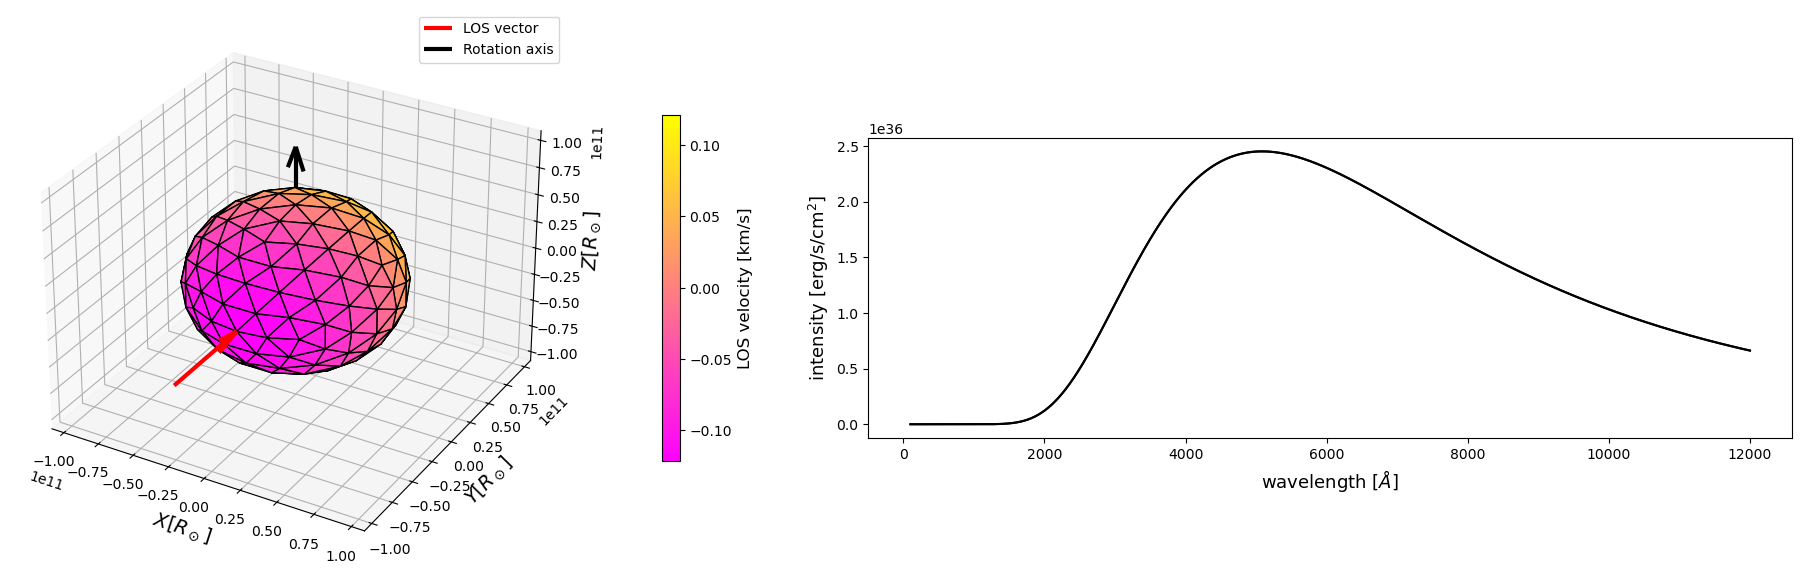

In [40]:
time_idx = 500
plot_3D_mesh_and_spectrum(mps[time_idx], vws, specs[time_idx], dict(property='los_velocities', cmap='spring'))

In [41]:
len(mps[::50])

20

In [42]:
# from spice.plots import animate_mesh_and_spectra
# 
# animate_mesh_and_spectra(mps[::50], TIMESTAMPS[::50], vws, specs[::50], 'pulsation.gif')

## Photometric time series

In [43]:
from spice.spectrum.filter import BesselU, BesselB, BesselV, Bolometric, GaiaG
from spice.spectrum.spectrum import AB_passband_luminosity

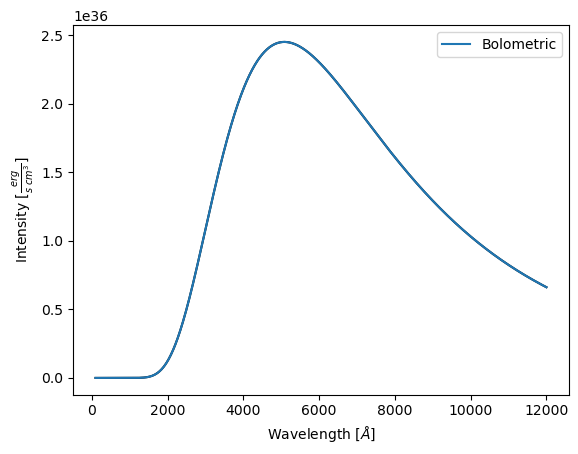

In [44]:
Bolometric().plot_filter_responses_for_wavelengths(vws, specs[0][:, 0])

In [45]:
bolometric = GaiaG()

In [46]:
d = u.AU.to(u.cm)
bolo = np.array([AB_passband_luminosity(bolometric, vws, flux[:, 0], distance=d) for flux in specs])

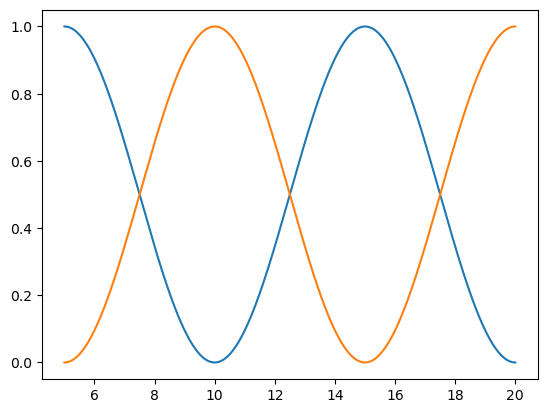

In [47]:
mean_radii = np.array(mean_radii)
plt.plot(TIMESTAMPS, (bolo - bolo.min()) / (bolo.max() - bolo.min()))
plt.plot(TIMESTAMPS, (mean_radii - mean_radii.min()) / (mean_radii.max() - mean_radii.min()))

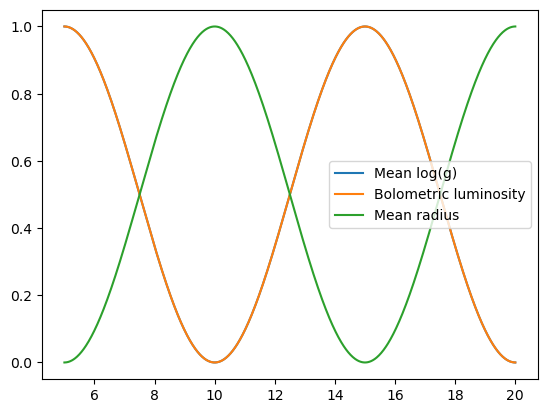

In [48]:
mean_loggs = np.array([jnp.mean(mp.log_gs) for mp in mps])
fig = plt.figure()
plt.plot(TIMESTAMPS, (mean_loggs-mean_loggs.min())/(mean_loggs.max()-mean_loggs.min()), label='Mean log(g)')
plt.plot(TIMESTAMPS, (bolo - bolo.min()) / (bolo.max() - bolo.min()), label='Bolometric luminosity')
plt.plot(TIMESTAMPS, (mean_radii - mean_radii.min()) / (mean_radii.max() - mean_radii.min()), label='Mean radius')
plt.legend()

In [49]:
fig.savefig('bolometric_pulsation.png')

In [50]:
from spice.spectrum.spectrum import luminosity

bls = [luminosity(bb.flux, mps1, vws) for mps1 in mps]

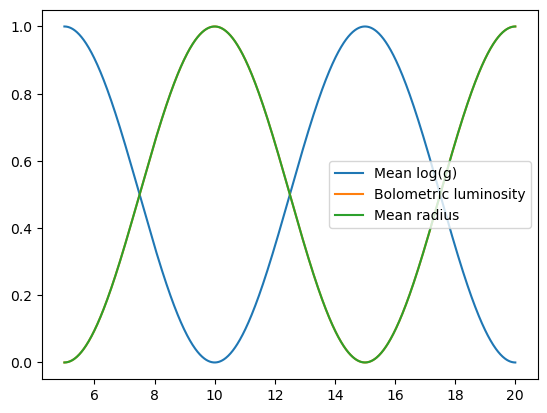

In [51]:
bls = np.array(bls)
fig = plt.figure()
plt.plot(TIMESTAMPS, (mean_loggs-mean_loggs.min())/(mean_loggs.max()-mean_loggs.min()), label='Mean log(g)')
plt.plot(TIMESTAMPS, (bls - bls.min()) / (bls.max() - bls.min()), label='Bolometric luminosity')
plt.plot(TIMESTAMPS, (mean_radii - mean_radii.min()) / (mean_radii.max() - mean_radii.min()), label='Mean radius')
plt.legend()

In [52]:
fig.savefig('total_luminosity_pulsation.png')

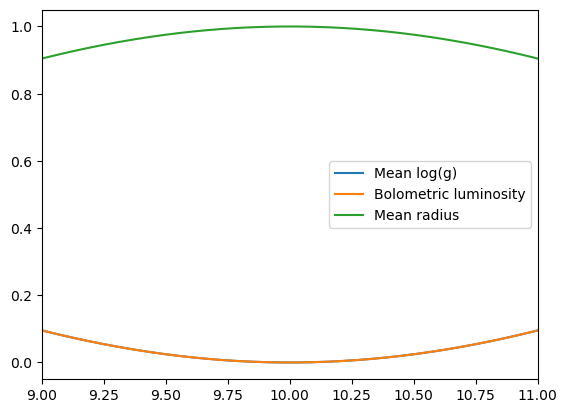

In [53]:
mean_loggs = np.array([jnp.mean(mp.log_gs) for mp in mps])
plt.plot(TIMESTAMPS, (mean_loggs-mean_loggs.min())/(mean_loggs.max()-mean_loggs.min()), label='Mean log(g)')
plt.plot(TIMESTAMPS, (bolo - bolo.min()) / (bolo.max() - bolo.min()), label='Bolometric luminosity')
plt.plot(TIMESTAMPS, (mean_radii - mean_radii.min()) / (mean_radii.max() - mean_radii.min()), label='Mean radius')
plt.gca().set_xlim(9, 11)
plt.legend()

In [54]:
plt.savefig('wierd.png')

<Figure size 640x480 with 0 Axes>

(9.0, 11.0)

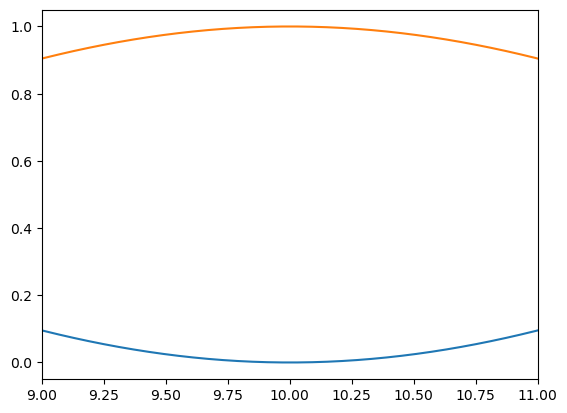

In [55]:
plt.plot(TIMESTAMPS, (bolo - bolo.min()) / (bolo.max() - bolo.min()))
plt.plot(TIMESTAMPS, (mean_radii - mean_radii.min()) / (mean_radii.max() - mean_radii.min()))
plt.gca().set_xlim(9, 11)

In [56]:
bessel_B = BesselB()
bessel_U = BesselU()
bessel_V = BesselV()

In [57]:
d = u.AU.to(u.cm)
U_phot = np.array([AB_passband_luminosity(bessel_U, vws, flux[:, 0], distance=d) for flux in specs])
B_phot = np.array([AB_passband_luminosity(bessel_B, vws, flux[:, 0], distance=d) for flux in specs])
V_phot = np.array([AB_passband_luminosity(bessel_V, vws, flux[:, 0], distance=d) for flux in specs])

# Calculate color indices
U_B = U_phot - B_phot
B_V = B_phot - V_phot


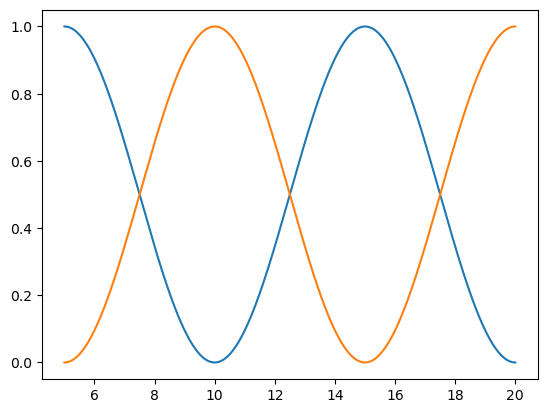

In [58]:
mean_radii = np.array(mean_radii)
plt.plot(TIMESTAMPS, (V_phot-V_phot.min())/(V_phot.max()-V_phot.min()))
plt.plot(TIMESTAMPS, (mean_radii-mean_radii.min())/(mean_radii.max()-mean_radii.min()))

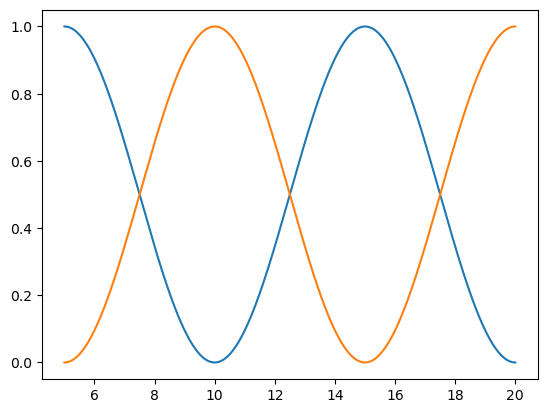

In [59]:
mean_radii = np.array(mean_radii)
plt.plot(TIMESTAMPS, (V_phot-V_phot.min())/(V_phot.max()-V_phot.min()))
plt.plot(TIMESTAMPS, (mean_radii-mean_radii.min())/(mean_radii.max()-mean_radii.min()))

(9.0, 11.0)

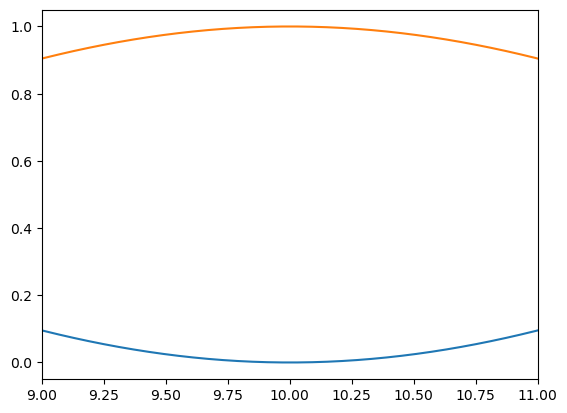

In [60]:
plt.plot(TIMESTAMPS, (V_phot-V_phot.min())/(V_phot.max()-V_phot.min()))
plt.plot(TIMESTAMPS, (mean_radii-mean_radii.min())/(mean_radii.max()-mean_radii.min()))
plt.gca().set_xlim(9, 11)

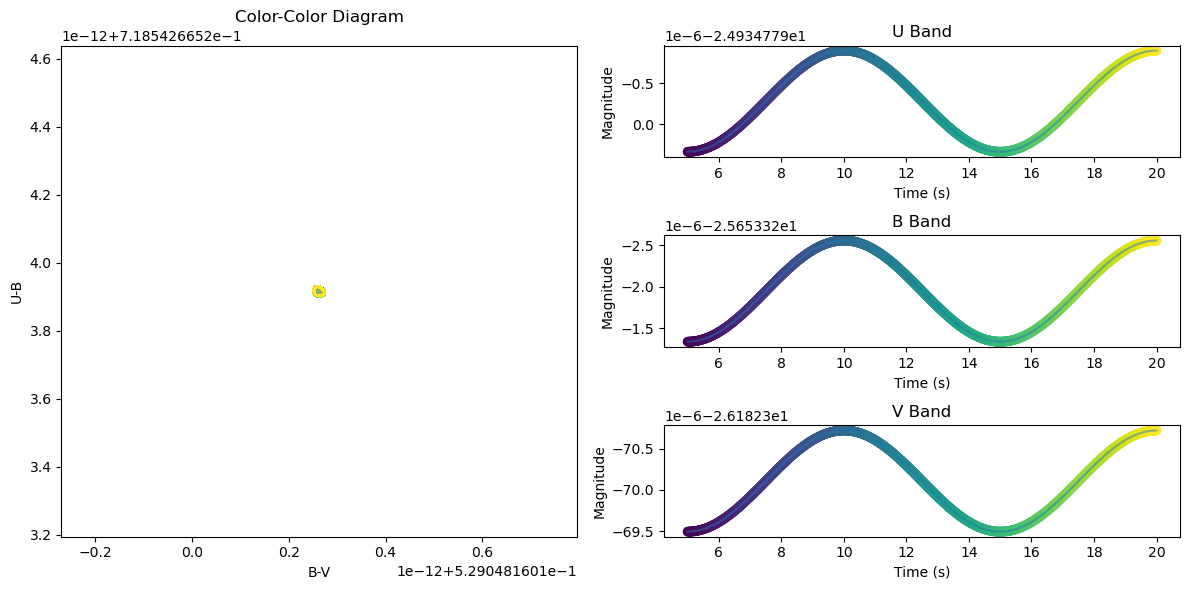

In [61]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Plot color-color diagram
ax_color = fig.add_subplot(gs[:, 0])
ax_color.plot(B_V, U_B, alpha=0.5)
ax_color.scatter(B_V, U_B, c=TIMESTAMPS, cmap='viridis')
ax_color.set_xlabel('B-V')
ax_color.set_ylabel('U-B')
ax_color.set_title('Color-Color Diagram')

# Photometry data and labels for loop
phot_data = [U_phot, B_phot, V_phot]
labels = ['U Band', 'B Band', 'V Band']

# Create photometry magnitude time series plots
for i, (data, label) in enumerate(zip(phot_data, labels)):
    ax = fig.add_subplot(gs[i, 1])
    ax.plot(TIMESTAMPS, data, label=label, alpha=0.5)
    ax.scatter(TIMESTAMPS, data, c=TIMESTAMPS, cmap='viridis', label='Markers')

    ax.set_title(label)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Magnitude')
    ax.invert_yaxis()

plt.tight_layout()

In [35]:
from astropy.timeseries import LombScargle
frequency = np.linspace(1/25, 1, 10000)
power = LombScargle(TIMESTAMPS[10:], U_phot[10:]).power(frequency)

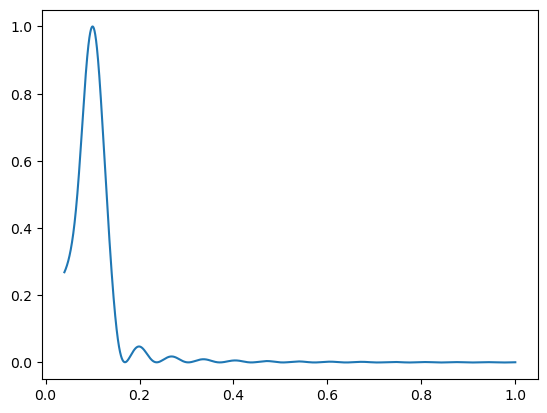

In [36]:
plt.plot(frequency, power)

In [37]:
1/frequency[np.argmax(power)]

9.999399975999038